<a href="https://colab.research.google.com/github/jagvgithub/LAOM/blob/main/PRUEBA_APLICACION_LAOM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# `Prueba de aplicación Opportunities@MeLi `

Luis Alfonso Orjuela Montoya

Data Scientist

Agosto 2024


# Ejercicio de aplicación

*Description:*

In the context of Mercadolibre's Marketplace an algorithm is needed to predict if an item listed in the marketplace is new or used.

Your tasks involve the data analysis, designing, processing and modeling of a machine learning solution to predict if an item is new or used and then evaluate the model over held-out test data.

To assist in that task a dataset is provided in `MLA_100k_checked_v3.jsonlines` and a function `build_dataset` to read that dataset in `new_or_used.py`.

For the evaluation, you will use the accuracy metric in order to get a result of 0.86 as minimum. Additionally, you will have to choose an appropriate secondary metric and also elaborate an argument on why that metric was chosen.

*Deliverables*

The following items should be addressed in your solution keeping in mind collaborative development such as code reproducibility and legibility.

- The scripts or runnable notebooks should include the necessary code needed to define and evaluate a model.

- A document with an explanation on the criteria applied to choose the features, the proposed secondary metric and the performance achieved on that metrics. Optionally, you can deliver an EDA analysis with other format like .ipynb


# Librerías necesarias para el desarrollo del ejercicio

In [6]:
''' Manipulación y análisis de datos '''
import pandas as pd
''' Operaciones numéricas '''
import numpy as np
''' Gráficos '''
import seaborn as sns
import matplotlib.pyplot as plt
''' Manipulación y tratamiento de archivos json '''
import json
from pandas import json_normalize
''' convertir diccionarios de características en vectores numéricos para el aprendizaje automático '''
from sklearn.feature_extraction import DictVectorizer
''' Modelo de regresión logística -- modelo de clasificación '''
from sklearn.linear_model import LogisticRegression
''' Métricas de evaluación y rendimiento del modelo '''
from sklearn.metrics import accuracy_score, classification_report
''' Transformaciones secuenciales en los datos de entrenamiento '''
from sklearn.pipeline import make_pipeline
''' Clasificador Random Forest problemas de clasificación'''
from sklearn.ensemble import RandomForestClassifier

In [7]:
def build_dataset():
    data = [json.loads(x) for x in open("MLA_100k_checked_v3.jsonlines")]
    target = lambda x: x.get("condition")
    N = -10000
    X_train = data[:N]
    X_test = data[N:]
    y_train = [target(x) for x in X_train]
    y_test = [target(x) for x in X_test]
    for x in X_test:
        del x["condition"]
    return X_train, y_train, X_test, y_test

def flatten_dict(d, parent_key='', sep='_'):
    """Aplana un diccionario anidado y convierte todos los valores a strings."""
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, str(v)))  # Convertimos el valor a string
    return dict(items)

if __name__ == "__main__":
    print("Loading dataset...")
    X_train, y_train, X_test, y_test = build_dataset()

Loading dataset...


# Análisis exploratorio de datos (EDA)

In [8]:
''' normalizar archivo json y conversión a DataFrame '''
''' Información de entrenamiento '''

df_train = json_normalize(X_train, sep='_')
df_train = pd.DataFrame(df_train)
df_train['target'] = y_train

df_train['target'] = np.where(df_train['target']=='used',0,1)

''' Eliminación de variables indicadoreas  para el EDA '''
df_train = df_train.drop(['condition','last_updated','international_delivery_mode','seller_address_city_id','seller_address_state_id','id','permalink','date_created','title','thumbnail','start_time','secure_thumbnail','stop_time','seller_address_country_name','site_id','seller_id'], axis=1)

''' Definir los campos sobre los cuales se va a realizar el EDA '''
df_train = df_train.select_dtypes(include=['number', 'object'])

''' Eliminación de aquellas variables que pueden ser contantes o no contienen información '''
df_train = df_train.applymap(lambda x: x if str(x) != '[]' else None).dropna(axis=1)

print(f' Las dimensiones del DataFrame de entrenamiento son :  {df_train.shape} \n')
display(df_train.head())


<ipython-input-8-1736f9ba239d>:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_train = df_train.applymap(lambda x: x if str(x) != '[]' else None).dropna(axis=1)


 Las dimensiones del DataFrame de entrenamiento son :  (90000, 16) 



,base_price,listing_type_id,price,buying_mode,listing_source,category_id,currency_id,status,initial_quantity,sold_quantity,available_quantity,seller_address_country_id,seller_address_state_name,seller_address_city_name,shipping_mode,target
0,80.0,bronze,80.0,buy_it_now,,MLA126406,ARS,active,1,0,1,AR,Capital Federal,San Cristóbal,not_specified,1
1,2650.0,silver,2650.0,buy_it_now,,MLA10267,ARS,active,1,0,1,AR,Capital Federal,Buenos Aires,me2,0
2,60.0,bronze,60.0,buy_it_now,,MLA1227,ARS,active,1,0,1,AR,Capital Federal,Boedo,me2,0
3,580.0,silver,580.0,buy_it_now,,MLA86345,ARS,active,1,0,1,AR,Capital Federal,Floresta,me2,1
4,30.0,bronze,30.0,buy_it_now,,MLA41287,ARS,active,1,0,1,AR,Buenos Aires,Tres de febrero,not_specified,0


# Análisis descriptivo del conjunto de datos

In [9]:
df_train.describe()

,base_price,price,initial_quantity,sold_quantity,available_quantity,target
count,9.000000e+04,9.000000e+04,90000.000000,90000.000000,90000.000000,90000.000000
mean,5.781341e+04,5.781352e+04,34.957178,2.328044,34.700767,0.537244
std,9.089555e+06,9.089555e+06,421.091981,33.839328,420.811703,0.498614
min,8.400000e-01,8.400000e-01,1.000000,0.000000,1.000000,0.000000
25%,9.000000e+01,9.000000e+01,1.000000,0.000000,1.000000,0.000000
50%,2.500000e+02,2.500000e+02,1.000000,0.000000,1.000000,1.000000
75%,8.000000e+02,8.000000e+02,2.000000,0.000000,2.000000,1.000000
max,2.222222e+09,2.222222e+09,9999.000000,6065.000000,9999.000000,1.000000


# Cantidad de categorías por campo

In [11]:
category_counts = df_train.nunique()
display(category_counts)

,0
base_price,9594
listing_type_id,7
price,9595
buying_mode,3
listing_source,1
category_id,10491
currency_id,2
status,4
initial_quantity,425
sold_quantity,304


# Distribución de clases de la variable de interés

In [ ]:
df_train['target'].value_counts()

,count
target,
1,48352
0,41648


Cuando se presenta una diferencia significativa en la representación de las clases a predecir (Este no es el caso) se hace necesario aplicar técnicas de remuestreo SMOTE (Synthetic Minority Over-sampling Technique), una libreía muy completa en este ámbito es : `Scikit-learn` que cuenta con las siguientes técnicas:

1. SMOTENC (SMOTE for Continuous and Categorical features)


- Es una variante del algoritmo SMOTE que maneja tanto características continuas como categóricas. Aplica SMOTE en las características continuas y genera muestras sintéticas considerando las características categóricas.



2. SMOTEN (SMOTE for Nominal features)

- Está diseñado específicamente para datasets con características categóricas. Genera nuevas muestras sintéticas basadas en las frecuencias y combinaciones de las categorías existentes en el dataset.

3. BorderlineSMOTE


- Es una variante de SMOTE que se enfoca en los ejemplos cercanos a la frontera de decisión entre las clases. Genera nuevas muestras sintéticas solo para los ejemplos que están cerca de los límites de las clases.


4. SVMSMOTE

- Utiliza una máquina de soporte vectorial (SVM) para identificar los ejemplos frontera y luego aplica SMOTE para generar ejemplos sintéticos cerca de estas fronteras.


5. ADASYN (Adaptive Synthetic Sampling)

- Ajusta la cantidad de ejemplos sintéticos generados para cada muestra minoritaria según la dificultad de la clasificación. Genera más ejemplos sintéticos para las muestras que son más difíciles de clasificar.


6. KMeansSMOTE

- Aplica un agrupamiento (clustering) usando K-Means antes de aplicar SMOTE. Esto permite generar ejemplos sintéticos dentro de los clústeres identificados.

**Las técnicas mencionadas deben ser aplicadas de manera adecuada para evitar inconvenientes en los datos como por ejemplo el sobreajuste, el ruido, complejidad computacional, distorsión en la distribución de los datos, confianza falsa, entre otros **

# Análisis de datos faltantes

Un tema de crucial importancia y que va a marcar la diferencia en los resultados y en la respectiva toma de desiciones sin duda alguna es la imputación de datos faltantes a partir del conocimiento exhaustivo de las fuentes de información, así como del criterio experto del dueño de los datos.

Se puede hacer uso de diferentes técnicas de imputación como lo son :

- Datos MCAR (Completamente al azar)
- Datos NMAR (No al azar)
- Datos MAR  (Al azar)
- Imputación simple (moda - mediana)
- Imputación Cold Deck (Uso de datos históricos similares)
- Imputación Hot Deck (Duplicación con registros similares)
- Imputación por regresión (Generar datos a partir de las variables correlacionadas) $y_i = \beta_0 + \beta_1 x_i + \epsilon$
- Imputación múltiple (Simulación de datos mediante cadenas de Markov y uso de inferencia bayesiana)


In [ ]:
proporcion_datos_faltantes = (round(df_train.isnull().sum() / len(df_train),2) * 100).sort_values(ascending=False)
df_missing = pd.DataFrame(proporcion_datos_faltantes)
df_missing = df_missing.reset_index()
df_missing.columns = ['Campo', '%_valores_nulos']
display(df_missing)

,Campo,%_valores_nulos
0,base_price,0.0
1,listing_type_id,0.0
2,price,0.0
3,buying_mode,0.0
4,listing_source,0.0
5,category_id,0.0
6,currency_id,0.0
7,status,0.0
8,initial_quantity,0.0
9,sold_quantity,0.0


# Distribución de datos

Para este apartado se realizó un análisis de frecuencias para las variables categóricas, mientras que para las variables numéricas se hace uso de diagramas de caja para determinar el comportamiento global de cada una de las variables.

_Variables Categóricas_

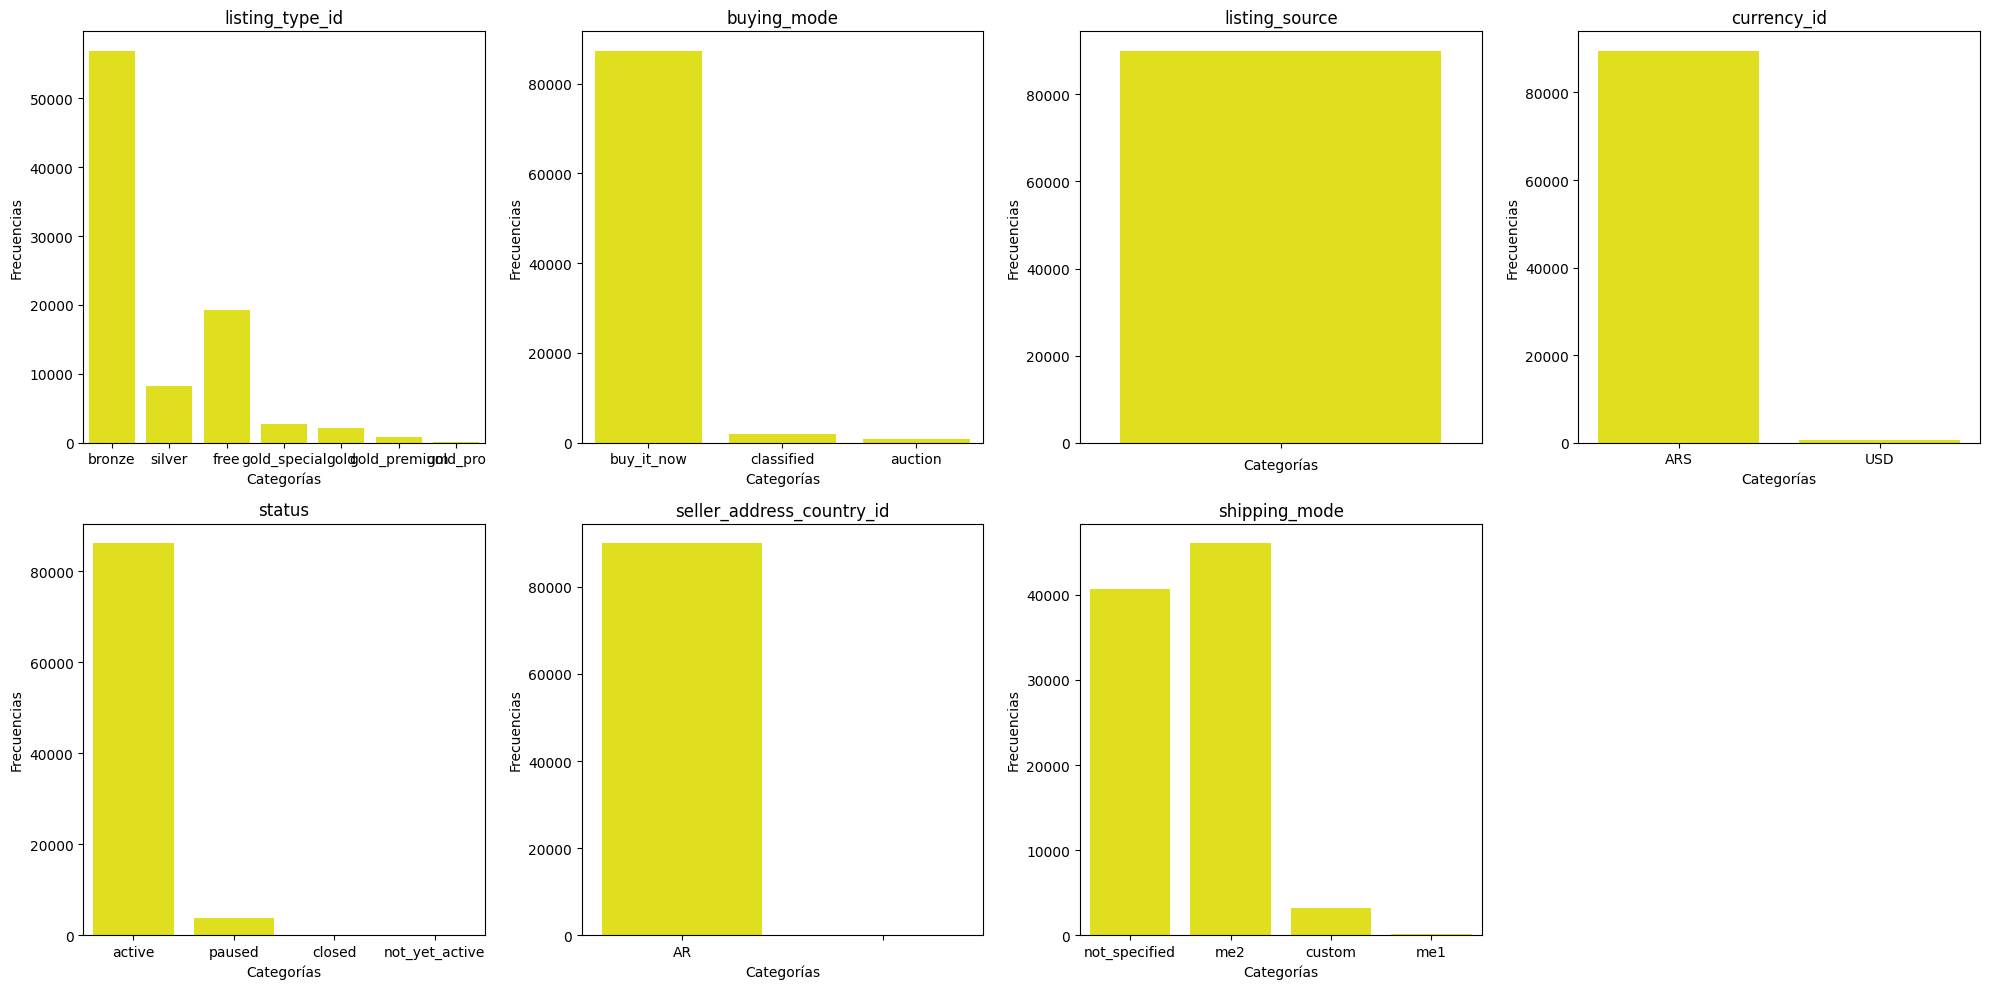

In [ ]:
''' Definir aquellas variables que contiene hasta 10 categorías '''

num_rows = (df_train.select_dtypes(include='object').apply(pd.Series.nunique) < 10).sum() // 4 + 1
fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(20, 5 * num_rows))
axes = axes.flatten()

i = 0
for col in df_train.select_dtypes(include='object'):
    if  df_train[col].nunique() < 11:
        sns.countplot(x=df_train[col], ax=axes[i], color='yellow')
        axes[i].set_title(col)
        axes[i].set_xlabel("Categorías")
        axes[i].set_ylabel("Frecuencias")
        i += 1

for j in range(i, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

_Variables Numéricas_

_Excluyendo outliers_

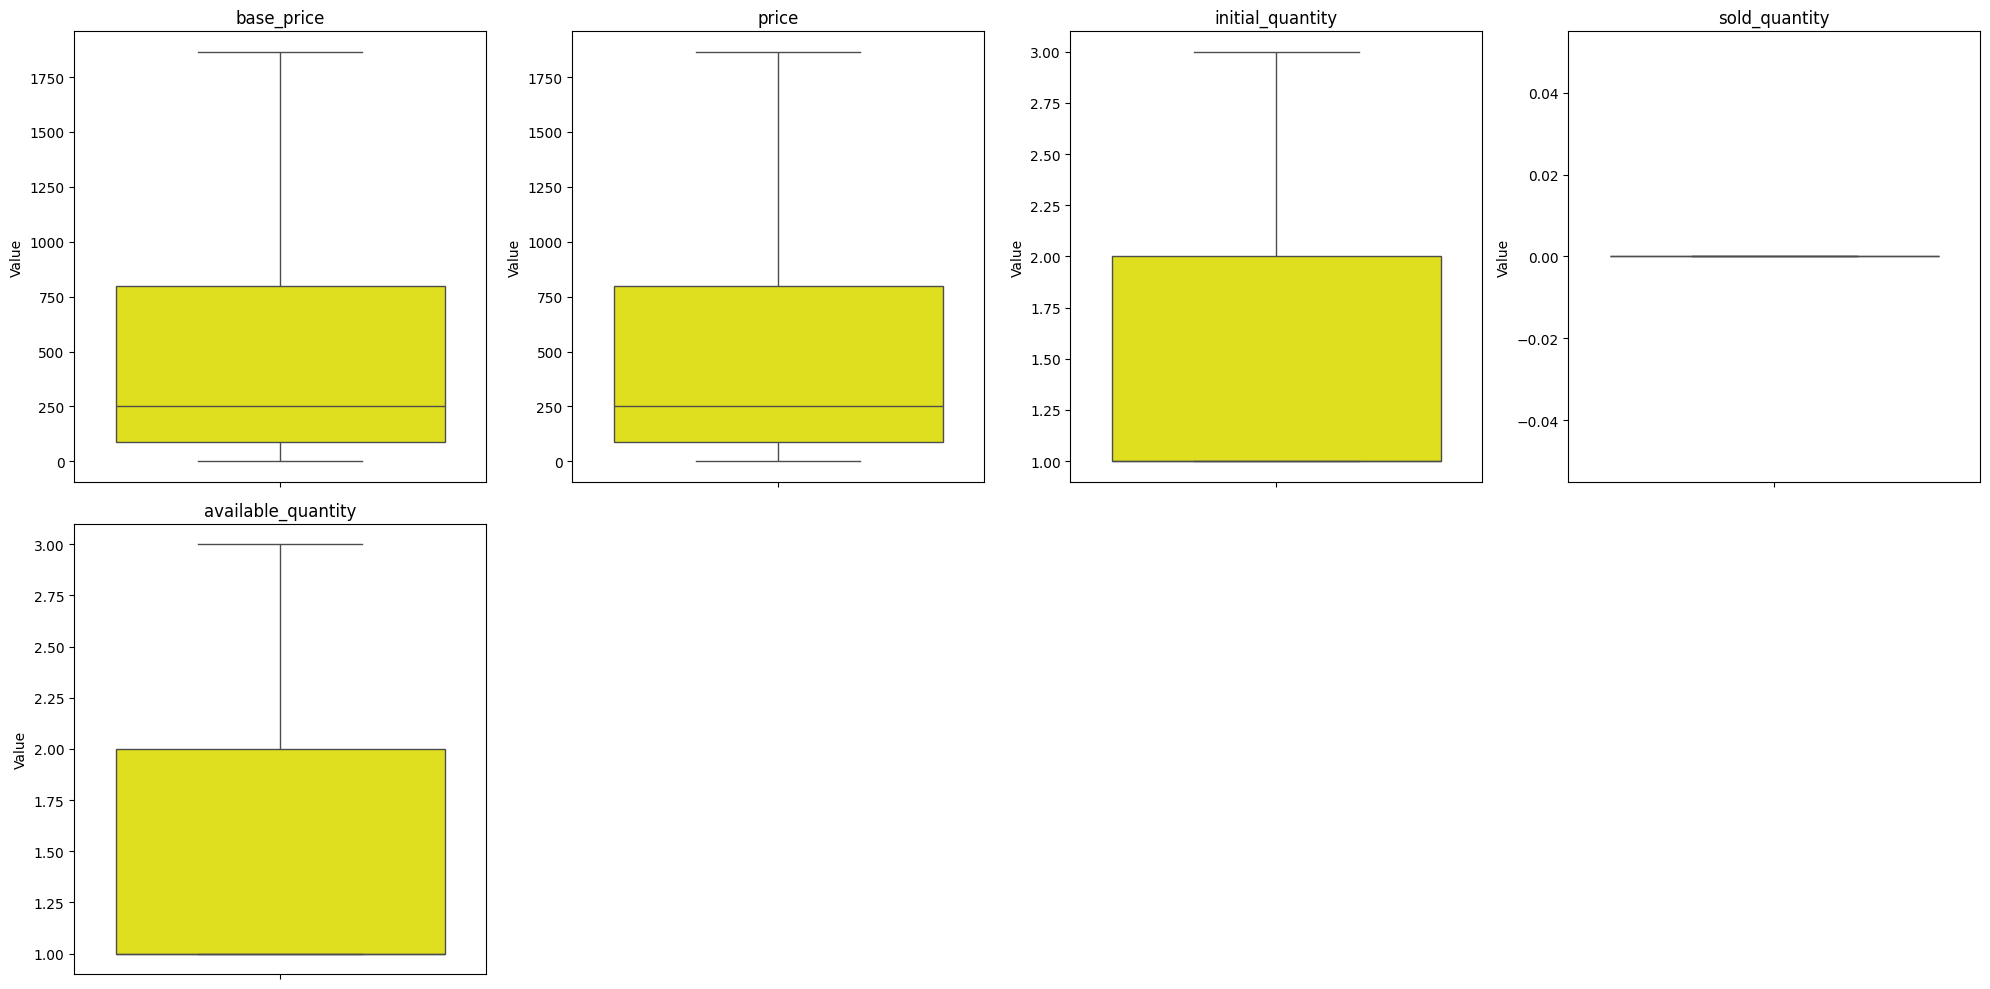

In [ ]:
''' Definir aquellas variables que contiene hasta 10 categorías '''

num_rows = (df_train.select_dtypes(include='number').apply(pd.Series.nunique) > 1).sum() // 4 + 1
fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(20, 5 * num_rows))
axes = axes.flatten()

i = 0
for col in df_train.select_dtypes(include='number'):
    if df_train[col].nunique() > 2:
        sns.boxplot(y=df_train[col], ax=axes[i], color='yellow', showfliers=False)
        axes[i].set_title(col)
        axes[i].set_ylabel("Value")
        i += 1

for j in range(i, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

_Variables Numéricas_

_Incluyendo outliers_

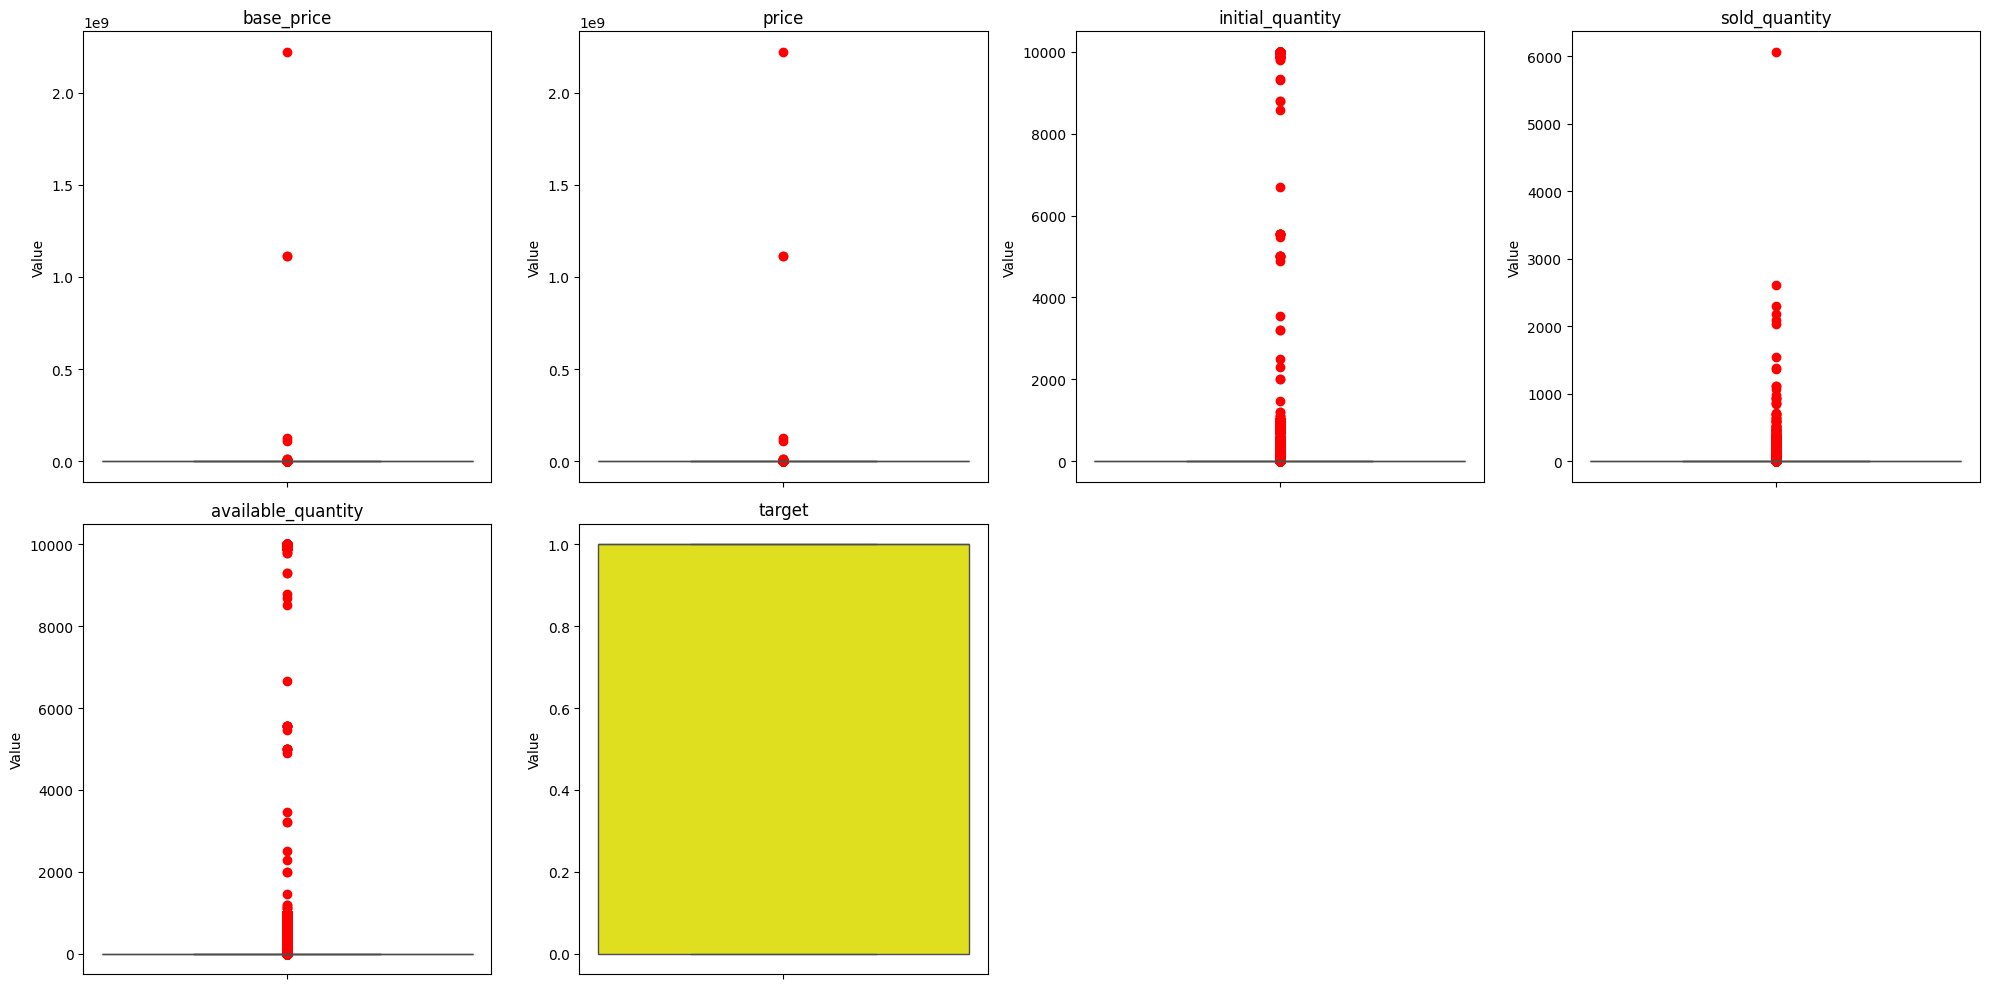

In [ ]:
''' Definir aquellas variables que contiene hasta 10 categorías '''

num_rows = (df_train.select_dtypes(include='number').apply(pd.Series.nunique) > 1).sum() // 4 + 1
fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(20, 5 * num_rows))
axes = axes.flatten()

i = 0
for col in df_train.select_dtypes(include='number'):
    if df_train[col].nunique() > 1:
        # IQR
        Q1 = df_train[col].quantile(0.25)
        Q3 = df_train[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Diagrama de caja
        sns.boxplot(y=df_train[col], ax=axes[i], color='yellow', showfliers=False)

        # definir valore atípicos
        outliers = df_train[col][(df_train[col] < lower_bound) | (df_train[col] > upper_bound)]
        axes[i].scatter(x=np.zeros_like(outliers), y=outliers, color='red', marker='o')

        axes[i].set_title(col)
        axes[i].set_ylabel("Value")
        i += 1

for j in range(i, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

Lo anterior nos permite tener un acercamiento hacia las fuentes de información y así conocer el comportamiento global de las variables `(En este caso particular se recomienda hacer un manejo adecuado de los valores atípicos para evitar sesgos en los resultados del modelo - procesos de normalización o de reducción de dimensionalidad)` y en este caso los clientes de cara al desarrollo de un modelo de aprendizaje automático que permite determinar con cierto nivel de probabilidad si la clasificación de un producto es nuevo o usado.

# Construcción, validación de modelo de aprendizaje automático con el conjunto de datos de entrenamiento.

Cargue de información con la función `build_dataset`

In [ ]:
def build_dataset():
    data = [json.loads(x) for x in open("MLA_100k_checked_v3.jsonlines")]
    target = lambda x: x.get("condition")
    N = -10000
    X_train = data[:N]
    X_test = data[N:]
    y_train = [target(x) for x in X_train]
    y_test = [target(x) for x in X_test]
    for x in X_test:
        del x["condition"]
    return X_train, y_train, X_test, y_test

def flatten_dict(d, parent_key='', sep='_'):
    """Aplana un diccionario anidado y convierte todos los valores a strings."""
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, str(v)))  # Convertimos el valor a string
    return dict(items)

if __name__ == "__main__":
    print("Loading dataset...")
    X_train, y_train, X_test, y_test = build_dataset()

    # Aplanamos los diccionarios anidados en las características
    X_train = [flatten_dict(x) for x in X_train]
    X_test = [flatten_dict(x) for x in X_test]

     #Alistamiento de información

    vectorizer = DictVectorizer()

    # Creamos un pipeline
    model = make_pipeline(
        vectorizer,
        RandomForestClassifier()
    )

    # Entrenamiento del modelo

    print("Modelo en proceso de entrenamiento...")
    model.fit(X_train, y_train)

    print("Modelo en proceso de Evaluación...")
    y_pred = model.predict(X_test)

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

Loading dataset...
Modelo en proceso de entrenamiento...
Modelo en proceso de Evaluación...
Accuracy: 0.8854
              precision    recall  f1-score   support

         new       0.88      0.91      0.90      5406
        used       0.89      0.85      0.87      4594

    accuracy                           0.89     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.89      0.89     10000



# Conclusiones del ejercicio :

- Se garantiza una Exactitud en el algoritmo de aprendizaje automático por medio del RandomForestClassifier() y que el modelo no es suceptible al orden de los valores de entrada como se puede ver por medio de la métrica: $$Macro \ avg = 0.88$$

Adicionalmente se evaluaron dos métricas, en primer lugar, el `Recall `(Exhaustividad - sensibilidad) que mide la proporción de verdaderos positivos, es decir, que un producto sea nuevo o usado cuando realmente es nuevo o usado respectivamente.

$$Recall = 0.89$$

Finalmente, la métrica `F1` es la media armónica de la precisión y la exhaustividad Proporcionando una medida equilibrada de la precisión del modelo, especialmente cuando hay un desequilibrio entre las clases que como se vió incialmente no es el caso.

$$F1 = 0.89$$




---
Cierre del ejercicio

---